# Машинное обучение

Выполнил: Вороненко Александр

Группа: 3824М1ФИ3

Датасет: https://www.kaggle.com/datasets/nphantawee/pump-sensor-data/data


## Структура

0. Импорт библиотек
1. Описание задачи
2. Чтение данных
3. Визуализация данных и вычисление основных характеристик. Интерпретирование
4. Обработка пропущенных значений
5. Обработка категориальных признаков
6. Нормализация
7. Разбиение данных
8. Запуск классификатора ближайших соседей
9. Подбор оптимальных значений к-ва ближайших соседей
10. Вычисление ошибки на обучающей и тестовой выборках
11. Другие классификаторы
12. Борьба с несбалансированностью классов
13. Исключение коррелированны переменных
14. Выводы



## 0. Импорт библиотек

In [ ]:
import os
import kagglehub
import zipfile
import shutil

import pandas as pd

import seaborn as sns

import numpy as np

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

## 1. Описание задачи

Есть насосная станция. Переодически происходят сбои и станция перестает работать.
У насосов есть 52 различных датчиков, с которых снимаются показания через равные промежутки времени.

Необходимо по показаниям датчиков попытаться предугадать следущий сбой.

### Интерпретация значений сенсоров



* SENSOR_00 - Motor Casing Vibration
* SENSOR_01 - Motor Frequency A
* SENSOR_02 - Motor Frequency B
* SENSOR_03 - Motor Frequency C
* SENSOR_04 - Motor Speed
* SENSOR_05 - Motor Current
* SENSOR_06 - Motor Active Power
* SENSOR_07 - Motor Apparent Power
* SENSOR_08 - Motor Reactive Power
* SENSOR_09 - Motor Shaft Power  
* SENSOR_10 - Motor Phase Current A
* SENSOR_11 - Motor Phase Current B
* SENSOR_12 - Motor Phase Current C
* SENSOR_13 - Motor Coupling Vibration
* SENSOR_14 - Motor Phase Voltage AB
* SENSOR_16 - Motor Phase Voltage BC
* SENSOR_17 - Motor Phase Voltage CA
* SENSOR_18 - Pump Casing Vibration
* SENSOR_19 - Pump Stage 1 Impeller Speed
* SENSOR_20 - Pump Stage 1 Impeller Speed
* SENSOR_21 - Pump Stage 1 Impeller Speed
* SENSOR_22 - Pump Stage 1 Impeller Speed
* SENSOR_23 - Pump Stage 1 Impeller Speed
* SENSOR_24 - Pump Stage 1 Impeller Speed
* SENSOR_25 - Pump Stage 2 Impeller Speed
* SENSOR_26 - Pump Stage 2 Impeller Speed
* SENSOR_27 - Pump Stage 2 Impeller Speed
* SENSOR_28 - Pump Stage 2 Impeller Speed
* SENSOR_29 - Pump Stage 2 Impeller Speed
* SENSOR_30 - Pump Stage 2 Impeller Speed
* SENSOR_31 - Pump Stage 2 Impeller Speed
* SENSOR_32 - Pump Stage 2 Impeller Speed
* SENSOR_33 - Pump Stage 2 Impeller Speed
* SENSOR_34 - Pump Inlet Flow
* SENSOR_35 - Pump Discharge Flow
* SENSOR_36 - Pump UNKNOWN
* SENSOR_37 - Pump Lube Oil Overhead Reservoir Level
* SENSOR_38 - Pump Lube Oil Return Temp
* SENSOR_39 - Pump Lube Oil Supply Temp
* SENSOR_40 - Pump Thrust Bearing Active Temp
* SENSOR_41 - Motor Non Drive End Radial Bearing Temp 1
* SENSOR_42 - Motor Non Drive End Radial Bearing Temp 2
* SENSOR_43 - Pump Thrust Bearing Inactive Temp
* SENSOR_44 - Pump Drive End Radial Bearing Temp 1
* SENSOR_45 - Pump non Drive End Radial Bearing Temp 1
* SENSOR_46 - Pump Non Drive End Radial Bearing Temp 2
* SENSOR_47 - Pump Drive End Radial Bearing Temp 2
* SENSOR_48 - Pump Inlet Pressure
* SENSOR_49 - Pump Temp Unknown
* SENSOR_50 - Pump Discharge Pressure 1
* SENSOR_51 - Pump Discharge Pressure 2

## 2. Чтение данных

Загрузим датасет с kaggle.

Для скачивания необходио быть зарегистрированным на kaggle, в настройках аккаунта нажать "создать токен", при этом скачается kaggle.json, который необходимо вставить в этот ноутбук в папку content

In [ ]:
dsAuthor_and_dsName = "nphantawee/pump-sensor-data"
dbName = "sensor.csv"

In [ ]:
if not os.path.exists("./kaggle.json"):
   raise Exception("kaggle.json not found. Please download kaggle.json from your kaggle accaunt and past in this notebook")

def unzip(file_path, delete=True):
  with zipfile.ZipFile(file_path, "r") as f:
    f.extractall()
  if delete:
    os.remove(file_path)

if not os.path.exists(f"./{dbName}"):
  path = kagglehub.dataset_download(dsAuthor_and_dsName, path=dbName)
  path = shutil.move(path, f"{dbName}.zip")
  unzip(path)

100%|██████████| 37.1M/37.1M [00:00<00:00, 57.3MB/s]


In [ ]:
db = pd.read_csv('./sensor.csv')
db.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


## 3. Визуализация данных и вычисление основных характеристик

In [ ]:
db.describe()

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,110159.500000,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,63601.049991,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,55079.750000,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,110159.500000,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,165239.250000,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,220319.000000,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


На первый взгляд все данные выглядят нормально, кроме первого столбца. Все значения сенсоров не сильно отличаются  

Выкенем первый столбец

In [ ]:
db.drop(db.columns[0], axis=1, inplace=True)

## 4. Обработка пропущенных значений


Проверим есть ли пропущенные значения

In [ ]:
db.isnull().sum()

,0
timestamp,0
sensor_00,10208
sensor_01,369
sensor_02,19
sensor_03,19
sensor_04,19
sensor_05,19
sensor_06,4798
sensor_07,5451
sensor_08,5107


В столбце "sensor_15" только NaN значения, уберем этот столбец и все строки с NaN значениями

In [ ]:
db.drop(['sensor_15'], axis=1, inplace=True)
db = db.dropna()

## 5. Обработка категориальных признаков


Посмотрим какие есть категории

In [ ]:
db.groupby('machine_status').size()

,0
machine_status,
BROKEN,5
NORMAL,116133
RECOVERING,2965


Переведем строковые признаки в числовые

In [ ]:
db.replace({'machine_status': {'RECOVERING': 2, 'BROKEN': 1, 'NORMAL': 0}}, inplace=True)

<ipython-input-10-cfff3e9f334f>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  db.replace({'machine_status': {'RECOVERING': 2, 'BROKEN': 1, 'NORMAL': 0}}, inplace=True)
<ipython-input-10-cfff3e9f334f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db.replace({'machine_status': {'RECOVERING': 2, 'BROKEN': 1, 'NORMAL': 0}}, inplace=True)


время не имеет для нас значение. Все показания идут друг за другом, за время можно принять номер строки, поэтому уберем этот столбец

In [ ]:
db.drop(['timestamp'], axis=1, inplace=True)

<ipython-input-11-87675fdd0180>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db.drop(['timestamp'], axis=1, inplace=True)


## 6. Коррелированны переменных

Выведем корреляционную матрицу в виде heatmap

<Axes: >

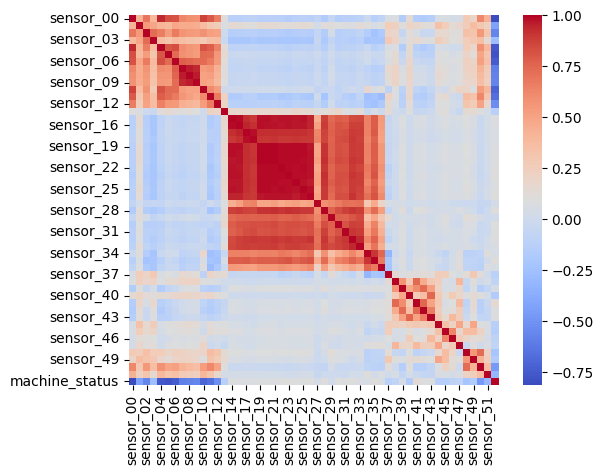

In [ ]:
corr_matrix = db.corr(numeric_only=True)

sns.heatmap(corr_matrix, square=True, cmap='coolwarm')


Видно, что весть сенсоры с сильной зависимостью, выведем их

In [ ]:
corr_matrix.where(np.triu(corr_matrix > 0.9, k=1)).stack().sort_values(ascending=False)


,,0
sensor_19,sensor_20,0.998727
sensor_20,sensor_21,0.997892
sensor_19,sensor_21,0.996586
sensor_20,sensor_23,0.992343
sensor_21,sensor_23,0.992206
...,...,...
sensor_34,sensor_35,0.903309
sensor_18,sensor_20,0.902285
sensor_22,sensor_28,0.901606
sensor_28,sensor_32,0.901448


## 7. Нормализация

In [ ]:
scaler = MinMaxScaler()
normalized_array = scaler.fit_transform(db)

normalized_db = pd.DataFrame(normalized_array, columns=db.columns)
normalized_db.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0.967194,0.739583,0.873046,0.872093,0.943770,0.764598,0.626734,0.683630,0.638905,0.602026,...,0.047664,0.057143,0.181429,0.069791,0.04363,0.292178,0.186992,0.221197,0.178327,0.0
1,0.967194,0.739583,0.873046,0.872093,0.943770,0.764598,0.626734,0.683630,0.638905,0.602026,...,0.047664,0.057143,0.181429,0.069791,0.04363,0.292178,0.186992,0.221197,0.178327,0.0
2,0.959089,0.747396,0.873046,0.877907,0.950518,0.735461,0.622673,0.679645,0.640988,0.600290,...,0.046711,0.055639,0.180000,0.070788,0.04363,0.287653,0.184282,0.219410,0.180709,0.0
3,0.965264,0.739583,0.871093,0.877907,0.934427,0.769891,0.622335,0.688535,0.644259,0.603184,...,0.043851,0.054135,0.177143,0.070788,0.04363,0.287653,0.182927,0.218517,0.180113,0.0
4,0.959475,0.740885,0.873046,0.877907,0.946884,0.765891,0.624027,0.687002,0.644259,0.603184,...,0.045758,0.052632,0.178571,0.072782,0.04712,0.292825,0.181572,0.220304,0.178327,0.0


Наши признаки также нормализовались. Вернем их обратно

In [ ]:
normalized_db['machine_status'] = normalized_db['machine_status'].replace({0.0: 0, 0.5: 1, 1.0: 2})

## 8. Разбиение данных

Посмотрим еще раз на количество записей для каждой категории

In [ ]:
normalized_db.groupby('machine_status').size()

,0
machine_status,
0.0,116133
1.0,5
2.0,2965


Видим, что для категории "1" (broken) всего 5 записей. Необходимо, чтобы в тренировочной и тестовой выборках обязательно были эти классы.

Пусть в тренировочной будет 3 записи, а в тестовой 2.

In [ ]:
X = normalized_db.drop(["machine_status"], axis = 1)
y = normalized_db["machine_status"]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [ ]:

y_test.value_counts()

,count
machine_status,
0.0,34845
2.0,884
1.0,2


## 8. Запуск классификатора ближайших соседей

In [ ]:
model = KNeighborsClassifier(n_neighbors=7, p=2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'Classification Report:\n {classification_report(y_test, y_pred)}')
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}')
print(f'Ошибка на train: {(1 - model.score(X_train, y_train))}')
print(f'Ошибка на test: {(1 - model.score(X_test, y_test))}')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     34845
         1.0       0.00      0.00      0.00         2
         2.0       0.99      1.00      1.00       884

    accuracy                           1.00     35731
   macro avg       0.66      0.67      0.67     35731
weighted avg       1.00      1.00      1.00     35731

Confusion Matrix:
 [[34840     0     5]
 [    1     0     1]
 [    2     0   882]]
Ошибка на train: 0.00014393321498828993
Ошибка на test: 0.0002518821191682674


## 9. Подбор оптимальных значений к-ва ближайших соседей

---



---



Созддим модели с разным числом соседей и посмотрим как будте изменяться ошибка

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

k_values = list(range(1, 12))
cv_scores = [cross_val_score(KNeighborsClassifier(n_neighbors=k), X_train, y_train, scoring='f1_weighted').mean() for k in k_values]

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Выведем в виде графика

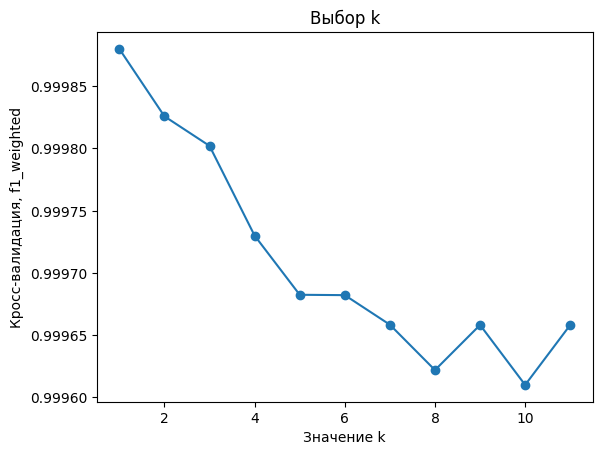

In [ ]:
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Значение k')
plt.ylabel('Кросс-валидация, f1_weighted')
plt.title('Выбор k')
plt.show()

## 10. Вычисление ошибки на обучающей и тестовой выборках

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

model = KNeighborsClassifier(n_neighbors=8, p=2)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_f1 = f1_score(y_train, y_pred_train, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

In [ ]:
print(f'Classification Report:\n{classification_report(y_test, y_pred_test)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred_test)}')
print(f'F1-метрика на train: {train_f1}')
print(f'F1-метрика на test: {test_f1}')

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     34845
         1.0       0.00      0.00      0.00         2
         2.0       0.99      0.99      0.99       884

    accuracy                           1.00     35731
   macro avg       0.66      0.66      0.66     35731
weighted avg       1.00      1.00      1.00     35731

Confusion Matrix:
[[34841     0     4]
 [    1     0     1]
 [    5     0   879]]
F1-метрика на train: 0.9998139866818191
F1-метрика на test: 0.9996641611902407


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 11. Другие классификаторы

## Градиентный бустинг

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)
gbc_y_pred = gbc.predict(X_test)

train_f1 = f1_score(y_train, gbc.predict(X_train), average='weighted')
test_f1 = f1_score(y_test, gbc_y_pred, average='weighted')

In [ ]:

print(f'Обучающая (F1): {train_f1}')
print(f'Тестовая (F1): {test_f1}')

Обучающая (F1): 0.9999790082612997
Тестовая (F1): 0.9997060820923471


## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
rfc_y_pred_train = rfc.predict(X_train)
rfc_y_pred_test = rfc.predict(X_test)

train_f1 = f1_score(y_train, rfc_y_pred_train, average='weighted')
test_f1 = f1_score(y_test, rfc_y_pred_test, average='weighted')

In [ ]:
print(f'Обучающая (F1): {train_f1}')
print(f'Тестовая (F1): {test_f1}')

Обучающая (F1): 1.0
Тестовая (F1): 0.9998041865559462


## 14. Выводы

Из-за сильной несбалансированности классов, сложно добиться результата, позволяющего предсказывать сбои в работе насосов по показаниям датчиков

Для улучшения результатов требуется либо большая выборка, либо эксперименты с более сложными моделями

Лучше всего справился с задаче RandomForest